# Evolutionary algorithm experiments

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import random

from constants import PATH_PURE_COMPONENTS, PATH_MIXTURES, X
from file_io import load_pickle_file
from nnls_fit_with_x_axis_correction import analyze, nnls_fit_with_interpolated_library
from utils import calculate_signal, nnls_fit, rsme
from correction_models import quadratic_correction

from numpy.random import normal

logging.basicConfig(level=logging.INFO)

## Load data

In [3]:
pure_components = load_pickle_file(PATH_PURE_COMPONENTS)
mixtures_data = load_pickle_file(PATH_MIXTURES)

## Experiment

### Constants

In [4]:
N_POPULATION = 200
N_SURVIVORS = 30
N_LINEAR_COMBINATIONS = 30
N_MUTATIONS = 100
INIT_GUESS = [0, 0, 0]
INIT_DEVIATIONS = [0.01, 0.1, 1]
N_MAX_GENERATIONS = 300
RSME_THRESHOLD = 1
N_STEADY_THRESHOLD = 50

In [5]:
correction_model = quadratic_correction
x_original = X
signal = mixtures_data[0]['signal']
true = mixtures_data[0]['contributions']

In [6]:
parameters = []
for _ in range(N_POPULATION):
    candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(INIT_GUESS, INIT_DEVIATIONS)]
    parameters.append(candidate)
parameters = np.array(parameters) 

min_rsme = float(np.inf)
best_solution = None
all_rsme_values = []
counter = 0

In [7]:
for k in range(1, N_MAX_GENERATIONS):
    counter += 1
    rsme_values = []
    
    for candidate in parameters:
        x_target = correction_model(x_original, candidate)
        
        if min(x_target) < -50:
            rsme_values.append(float(np.inf))
            continue
        if max(x_target) > 150:
            rsme_values.append(float(np.inf))
            continue
            
        solution, residual = nnls_fit_with_interpolated_library(x_original, x_target, pure_components, signal)
        rsme_value = rsme(residual)
        rsme_values.append(rsme_value)
        if rsme_value < min_rsme:
            min_rsme = rsme_value
            best_solution = solution
            counter = 0
            print(k, min_rsme, solution)
    
    all_rsme_values.append(rsme_values)
    
    if min_rsme < RSME_THRESHOLD:
        print(f'Target RSME treshold reached. Iteration terminated at round {k}.')
        break
        
    if counter > N_STEADY_THRESHOLD:
        print(f"RSME didn't change in last {N_STEADY_THRESHOLD} rounds. Iteration terminated at round {k}.")
        break
    
    sorted_indices = np.argsort(rsme_values)
    survivors = parameters[sorted_indices][:N_SURVIVORS]
    best_parameters = survivors[0]

    parameters = []
    parameters.append(best_parameters)

    for _ in range(N_LINEAR_COMBINATIONS):
        candidate = [random.choice(column) for column in survivors.T]
        parameters.append(candidate)

    for _ in range(N_MUTATIONS):
        candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(best_parameters, INIT_DEVIATIONS)]
        parameters.append(candidate)

    for _ in range(N_POPULATION - len(parameters)):
        candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(INIT_GUESS, INIT_DEVIATIONS)]
        parameters.append(candidate)
    
    parameters = np.array(parameters)

print('True contributions: ', true)

1 397.6354323978395 [ 22.93681107 379.79457428 104.01265429]
1 153.50620866777683 [ 26.48047689 401.23284563  43.41767272]
1 59.08164876903521 [ 28.02552106 406.7114874    0.        ]
2 54.1837160115064 [ 27.47152746 383.05897491   1.42254491]
3 52.4424807372524 [ 27.45874737 402.4974974    0.        ]
3 46.689236478963856 [ 28.25213898 402.2751003    0.        ]
3 40.98372723404363 [ 26.28471376 377.66840546  25.15037575]
3 11.977130739323222 [ 26.03508433 391.95784883   6.39823719]
8 3.1997944151696043 [ 25.80648409 390.25562094  13.53862995]
RSME didn't change in last 50 rounds. Iteration terminated at round 59.
True contributions:  [ 25.53884062 389.36144086  14.74869716]


C:\Users\ossi\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


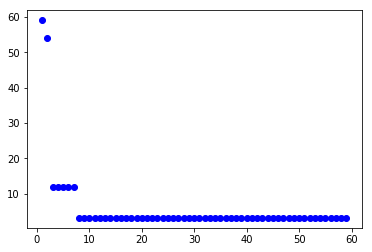

In [8]:
for i, row in enumerate(all_rsme_values,1):
    rsme_min = min(row)
    rsme_stdev = np.std(row)
    rsme_mean = np.mean(row)
    _ = plt.plot(i, rsme_min, 'bo')